# 1. Extract data from Web

In [66]:
# import cgi module to extract web content
import requests, re, sys

In [97]:
url = r'https://bittigermusicplayerdata.s3-us-west-2.amazonaws.com'

try:
    source = requests.get(url)
except requests.ConnectionError:
    sys.stderr.write('Link is invalid.')

In [110]:
from bs4 import BeautifulSoup

# beautiful soup is a package to pretify the html content display.
# create beautiful soup object 
#soup = BeautifulSoup(source.content, 'lxml')
#print(soup.prettify())

# use regular expression to extract download content
pattern = re.compile(r'''<key>(.*?)</key>''',re.I)
download_lists = pattern.findall(source.text)

# download the contents and save to files

for link in download_lists:
    with open(r'./data/'+link,'wb') as f:
        for chunk in requests.get(url+r'/'+link, stream = True).iter_content(chunk_size = 1024):
            if chunk:
                f.write(chunk)
        

# 2. Unzip the tar.gz and gz files respectively

In [21]:
import os, tarfile, gzip,sys

zippath = r'./Data'
unzippath = r'./UnzipData'

# access the zip files, unzip them, and write them into another folder.
zipfiles = os.listdir(zippath)
counter = 0

for file in zipfiles:
    counter += 1 # ensure walk through all files
    if file[-6:] == 'tar.gz':
        try: 
            with tarfile.open(os.path.join(zippath, file), 'r|gz') as inhandle:
                inhandle.extractall(os.path.join(unzippath,file))
        except tarfile.ReadError:
            sys.stderr.write(file)
     
    elif file[-2:] =='gz':
    
        with gzip.GzipFile(os.path.join(zippath, file), 'rb') as inhandle:
            content = inhandle.read()
        with open(os.path.join(unzippath, file[:file.rfind('.')]), 'wb') as outhandle:
            outhandle.write(content)
    else:  
        
        with open(os.path.join(zippath,file),'rb') as inhandle:
            content = inhandle.read()
        with open(os.path.join(unzippath, file), 'wb') as outhandle:
            outhandle.write(content)
    
print (counter) # ensure walk through all files

20170424_1_play.log.tar.gz20170424_2_play.log.tar.gz

409


# 3. Pre-process play.log files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

zippath = r'./Data'
unzippath = r'./UnzipData'

### 1. load one file as an example

In [7]:
# take one play.log to explore the data

filename = '20170302_1_play.log'

schema = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag']
df = pd.read_csv(os.path.join(unzippath, filename), sep = '\t+',header = None, index_col = None, names = schema, usecols = [0,1,2,3,4,5,6,7,8], engine = 'python')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453607 entries, 0 to 2453606
Data columns (total 9 columns):
uid            object
device         object
song_id        object
song_type      object
song_name      object
singer         object
play_time      object
song_length    object
paid_flag      object
dtypes: object(9)
memory usage: 168.5+ MB


In [9]:
df.head()

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag
0,264715,None,None,None,None,None,None,None,None
1,292363,None,None,None,None,None,None,None,None
2,154824972,ar,3300104,0,Not A Love Song,Bean,22,178,0
3,154431666,ar,6651913,0,再见只是陌生人,庄心妍,252,251,0
4,154439430,ar,20870987,0,哥哥,张杰,358,358,0


In [10]:
# exame the missing values
pd.DataFrame({"miss cnt" : df.isnull().sum(axis = 0),
              "miss prcnt %" : df.isnull().sum(axis = 0) / df.shape[0] * 100
             }
            )

,miss cnt,miss prcnt %
uid,0,0.000000
device,6,0.000245
song_id,6,0.000245
song_type,6,0.000245
song_name,659,0.026858
singer,1311,0.053432
play_time,1312,0.053472
song_length,1312,0.053472
paid_flag,1312,0.053472


In [11]:
# any entries that miss all feature values (except uid)?
df.loc[df.isnull().sum(axis = 1)>= df.shape[1]-1]

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag
0,264715,None,None,None,None,None,None,None,None
1,292363,None,None,None,None,None,None,None,None
774430,264715,None,None,None,None,None,None,None,None
774431,292363,None,None,None,None,None,None,None,None
1628541,264715,None,None,None,None,None,None,None,None
1628542,292363,None,None,None,None,None,None,None,None


In [12]:
# these lines add no value. Therefore remove.
df.drop(df.loc[df.isnull().sum(axis = 1)>= df.shape[1]-1].index, inplace = True)
df.loc[df.isnull().sum(axis = 1)>= df.shape[1]-1]

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag


The uid has no missing values.


Next step is to exame the data column by column

1)  Device

In [13]:
# exam the device column, and find that the column is contaminted by digits.
df['device'].unique()

array(['ar ', 'ip ', '1 ', '29 ', '37 ', '23 ', '35 ', '25 ', '40 ', '28 ',
       '32 ', '49 ', '2 ', '50 ', '0 ', '53 ', '52 ', '41 ', '168 ', '30 ',
       '24 ', '45 ', '44 ', '4 ', '31 ', '5 ', '7 ', '12 ', '27 ', '22 ',
       '26 ', '21 ', '38 ', '34 ', '8 ', '173 ', '14 ', '17 ', '33 ',
       '11 ', '20 ', '18 ', '423 ', '43 ', '1204 ', '1203 ', '985 ',
       '1201 ', '10 ', '3 ', '16 ', '6 ', '177 ', '60 ', '63 ', '55 ',
       '42 ', '19 ', '13 ', '47 ', '295 ', '202 ', '46 ', '197 ', '48 ',
       '54 ', '36 ', '39 ', '62 ', '57 ', '234 ', '9 ', '59 ', '172 ',
       '134 ', '72 ', '257 ', '15 ', '239 ', '195 ', '58 ', '64 ', '51 ',
       '68 ', '146 ', ' '], dtype=object)

In [14]:
df['device'].value_counts().head(20)

ar     2071343
ip      381605
0           47
33          30
32          28
30          26
29          25
28          24
1           23
31          21
20          19
23          18
34          17
26          14
4           13
38          13
2           13
27          13
3           12
35          12
Name: device, dtype: int64

In [15]:
# based on the research, the device should only be either "ar" or "ip". Clear the other values.
print("Other Values:", df['device'].loc[(df['device'].str.strip()!='ar') & (df['device'].str.strip()!='ip')].count())
df['device'].loc[(df['device'].str.strip()!='ar') & (df['device'].str.strip()!='ip')] = None
df['device'].value_counts()

Other Values: 653


ar     2071343
ip      381605
Name: device, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1141147b8>], dtype=object)

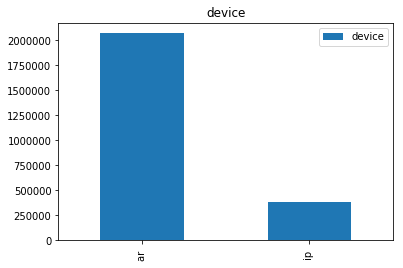

In [16]:
pd.DataFrame(df['device'].value_counts()).plot(kind = 'bar', subplots = True)

"ar" users outweights the "ip" users. if the consolidated data shows the same issue, dowmsampling may be required.

2) song_id

In [17]:
df['song_id'].unique()

array(['3300104 ', '6651913 ', '20870987 ', ..., '4749440 ', '692645 ',
       '3335630 '], dtype=object)

song_id should be all digits. check if any entry contains characters.

In [18]:
song_id_num = pd.to_numeric(df['song_id'], errors = 'coerce')
df['song_id'][pd.isna(song_id_num)].value_counts().head(20)

                             8050
620(1.63.112.157)TM            10
35(112.12.40.230)TM             8
(1.63.112.157)TM                7
666069(182.245.19.208)TM        6
61485(182.240.247.203)TM        6
9(153.0.241.185)TM              5
2(123.11.113.20)TM              5
438220(223.245.138.63)TM        5
40567(223.244.66.80)TM          4
620(61.167.200.157)TM           4
35(117.149.49.177)TM            4
39795(112.11.80.15)TM           4
5911(39.183.138.207)TM          4
(61.167.200.157)TM              4
67059(114.106.26.149)TM         4
140138(114.106.26.149)TM        4
69(61.167.200.157)TM            4
6(112.11.206.101)TM             4
4203733(1.63.112.157)TM         3
Name: song_id, dtype: int64

In [19]:
# clear the song_id's that contain characters
df['song_id'][pd.isna(song_id_num)] = None
df['song_id'][pd.isna(song_id_num)].head(5)

198     None
387     None
410     None
2888    None
3002    None
Name: song_id, dtype: object

3) song_type

In [20]:
df['song_type'].value_counts()

0                        2149504
1                         265979
2                          25324
                           12017
0                            653
(61.167.200.227)TM             7
(1.63.112.157)TM               4
(220.165.106.60)TM             3
(112.12.41.169)TM              3
(39.183.144.164)TM             3
(112.12.65.34)TM               3
0(220.165.107.67)TM            3
(61.166.159.252)TM             3
(111.19.112.138)TM             3
(182.243.25.180)TM             3
0(220.165.106.60)TM            2
(223.104.145.19)TM             2
(223.94.196.10)TM              2
0(61.167.200.227)TM            2
0(1.63.112.157)TM              2
0(112.11.86.34)TM              2
(117.148.125.119)TM            2
0(39.187.200.55)TM             2
0(39.188.144.196)TM            2
0(117.148.119.127)TM           2
1(180.109.27.103)TM            2
0(39.183.138.207)TM            2
0(116.249.186.241)TM           2
0(182.246.211.72)TM            2
0(112.11.194.110)TM            1
          

see characters in the field. Process the columns in the same way as song_id

In [21]:
song_type_num = pd.to_numeric(df['song_type'], errors = 'coerce')
df['song_type'][pd.isna(song_type_num)].value_counts().head(20)

                        12017
(61.167.200.227)TM          7
(1.63.112.157)TM            4
(112.12.65.34)TM            3
(112.12.41.169)TM           3
0(220.165.107.67)TM         3
(39.183.144.164)TM          3
(182.243.25.180)TM          3
(220.165.106.60)TM          3
(111.19.112.138)TM          3
(61.166.159.252)TM          3
(117.148.125.119)TM         2
1(180.109.27.103)TM         2
0(39.188.144.196)TM         2
0(1.63.112.157)TM           2
0(61.167.200.227)TM         2
0(39.183.138.207)TM         2
0(182.246.211.72)TM         2
(223.94.196.10)TM           2
(223.104.145.19)TM          2
Name: song_type, dtype: int64

In [22]:
# clear the song_type's that contain characters
df['song_type'][pd.isna(song_type_num)] = None
df['song_type'][pd.isna(song_type_num)].head(5)

198    None
387    None
410    None
464    None
610    None
Name: song_type, dtype: object

4) Song Name could be any character. Therefore it is hard to spot errors

In [23]:
# take a deep look on the song names
df['song_name'][df['song_name'].str.find('哆啦A梦') != -1].value_counts().head(10)

哆啦A梦伴我同行                               14
哆啦A梦(23秒铃声版)                           12
向日葵的约定-(3D动画电影《哆啦A梦                     7
哆啦A梦                                    6
哆啦A梦(《哆啦A梦》动漫主题曲)                       5
哆啦A梦休假                                  4
向日葵的约定-(3D动画电影《哆啦A梦：伴我同行》官方中文版主题曲)      4
向日葵的约定(3D动画电影《哆啦A梦：伴我同行》官方中文版主题曲)       4
哆啦A梦主题歌                                 2
【诸葛亮×王司徒】联唱哆啦A梦 蓝胖子之歌                   2
Name: song_name, dtype: int64

5) singer. Check if contain special characters

In [24]:
df['singer'].value_counts().head(20)

未知歌手        77392
网络歌手        70541
儿童歌曲        47099
薛之谦         36741
张杰          35402
李玉刚         30709
手机铃声        28708
张碧晨&杨宗纬     26345
庄心妍         25650
赵雷          25103
周杰伦         21226
降央卓玛        21191
凤凰传奇        20844
铃声          20458
DJ舞曲        18414
祁隆          18081
TFBOYS      17049
孙露          16997
张学友         16031
邓丽君         14695
Name: singer, dtype: int64

In [25]:
# take a deep look on the singers
df['singer'][df['singer'].str.find(r'~') != -1].value_counts().head(10)

【娱+543】小水 男声女声分不清楚~~     6
ぷ雨~蝶~                    4
【娱+】小水 琪宝宝又来了哈哈~~~       3
雪儿~~~                    2
金猪-﹏小乔~                  2
Ｃhinａ小甜甜 虎牙甜开心快乐每一天~     1
Q型地带ピ~                   1
Sound.L~萌子               1
⒐⒏0⒏ゞ甜甜，甜甜是宝 丢了难找~!@     1
涵涵~~                     1
Name: singer, dtype: int64

In [26]:
# remoce the special characters
df['singer'] = df['singer'].str.replace(r'?','')

6) play time in seconds

In [27]:
play_time_num = pd.to_numeric(df['play_time'],errors = 'coerce')
df['play_time'][pd.isna(play_time_num)].value_counts().head()

                           15037
5>(121.12.5.95)TM             59
5>=(183.198.238.54)TM         35
5>(27.199.224.213)TM          34
5>}(27.199.224.213)TM        27
Name: play_time, dtype: int64

In [28]:
# convert the value into numerics
df['play_time'] = pd.to_numeric(df['play_time'],errors = 'coerce')
df['play_time'][pd.isna(df['play_time'])].head(20)

127    NaN
198    NaN
410    NaN
456    NaN
633    NaN
794    NaN
1147   NaN
1211   NaN
1921   NaN
2420   NaN
2486   NaN
2529   NaN
2600   NaN
2888   NaN
2903   NaN
2963   NaN
3002   NaN
3105   NaN
3389   NaN
3567   NaN
Name: play_time, dtype: float64

7) song length

In [29]:
song_length_num = pd.to_numeric(df['song_length'],errors = 'coerce')
df['song_length'][pd.isna(song_length_num)].value_counts().head()

                         7660
2(116.249.186.241)TM       11
(114.106.26.149)TM          8
(111.19.75.66)TM            5
2(118.124.229.106)TM        4
Name: song_length, dtype: int64

In [30]:
# convert the value into numerics
df['song_length'] = pd.to_numeric(df['song_length'],errors = 'coerce')
df['song_length'][pd.isna(df['song_length'])].head(20)

198     NaN
410     NaN
2888    NaN
3002    NaN
3567    NaN
3895    NaN
4116    NaN
4322    NaN
4968    NaN
4991    NaN
7464    NaN
8096    NaN
8104    NaN
8248    NaN
10354   NaN
10895   NaN
12074   NaN
13010   NaN
13202   NaN
13998   NaN
Name: song_length, dtype: float64

In [31]:
# the play_time should not be longer than the song_length
print("play_time > song_length", df.loc[df['play_time']> df['song_length'] * 1.5].shape[0])
df.loc[df['play_time']> df['song_length'] * 1.5].head(20)

play_time > song_length 239819


,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag
6,154798546,ar,2632638,0,旋转的潮流,Della,783.0,0.0,0
8,154785205,ar,502774,0,阿拉伯之夜,群星,10.0,0.0,0
12,154826319,ar,4251791,0,爱(2010年春晚歌曲 2010春晚歌曲),小虎队,27962.0,0.0,0
47,154439223,ar,19380090,1,找不到我们家啊,Mad Clown&脸红的思春期,215713.0,215.0,0
55,154439844,ar,20870989,1,Writing's on the wall,林志炫,290110.0,290.0,0
64,154439227,ar,6685516,0,我最红,2NE1,209627.0,210.0,0
67,154440199,ar,20940997,0,向往-(电视剧《鸡毛飞上天》主题曲),孙楠,246523.0,246.0,0
68,154439442,ar,20870992,0,盛夏光年,林忆莲,223061.0,223.0,0
73,154439867,ar,20870988,1,三十岁的女人,赵雷,321689.0,321.0,0
74,154782535,ar,703874,1,数鸭子,儿童歌曲,76751.0,77.0,0


8) Paid flag

In [33]:
df['paid_flag'].value_counts()

0          2452269
415             14
0                3
252              2
109411           1
105039           1
238              1
108947           1
"                1
237              1
288              1
Name: paid_flag, dtype: int64

In [ ]:
# flag should only be 0 or 1. There is no 1 in the column. So clear the cells with values other than 0.

In [47]:
df['paid_flag'][(df['paid_flag'].str.strip() != '0') & (df['paid_flag'].str.strip() != '1')]
df['paid_flag'][df['paid_flag'].str.find('0') != -1] = '0'
df['paid_flag'].value_counts()

/Users/tianyuanluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    2453601
Name: paid_flag, dtype: int64

9) Add the new feature, date, from the file name

In [62]:
df['log_date'] = filename.split('_')[0]
df['log_date'] = pd.to_datetime(df['log_date'], yearfirst = True, format = '%Y-%m-%d')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453601 entries, 2 to 2453606
Data columns (total 10 columns):
uid            object
device         object
song_id        object
song_type      object
song_name      object
singer         object
play_time      float64
song_length    float64
paid_flag      object
log_date       datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 285.9+ MB


### In summary, the play_log should be processed through the following steps:

    1) Only load the first 9 columns based on the schema

    2) Remove the rows with all None's except the uid column

    3) Clear the device types other than 'ar' or 'ip'

    4) Clear the song id's with non-numerical characters

    5) Clear the song types with non-numerical characters

    6) Remove "?" from the singer names

    7) Convert the play_time into float

    8) Convert the song_length into float

    9) Clear the paid_flag with other than "0" or "1"
    
    10) add the log_date from the first 8 characters of the file name

## 4. Pre-processing download log

In [64]:
# load an example

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

zippath = r'./Data'
unzippath = r'./UnzipData'

In [66]:
filename = '30_1_down.log'

schema = ['uid','device','song_id','song_name','singer','paid_flag']
df_1 = pd.read_csv(os.path.join(unzippath, filename), sep = '\t+',header = None, index_col = None, names = schema, usecols = [0,1,2,3,4,5], engine = 'python')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160261 entries, 0 to 160260
Data columns (total 6 columns):
uid          160261 non-null object
device       160261 non-null object
song_id      160073 non-null float64
song_name    160073 non-null object
singer       159885 non-null object
paid_flag    159885 non-null object
dtypes: float64(1), object(5)
memory usage: 7.3+ MB


In [82]:
df_1.head()

,uid,device,song_id,song_name,singer,paid_flag
0,168019810,ar,442554.0,小酒窝,林俊杰&蔡卓妍,0
1,168019810,ar,6334611.0,社会摇,萧全,0
2,168019810,ar,9867382.0,台阶,武艺,0
3,168019810,ar,6660691.0,一次就好-(电影《夏洛特烦恼》暖水曲),杨宗纬,0
4,168019810,ar,157606.0,一路上有你,张学友,0


1) uid

In [74]:
# how unique the column is?

print ("total {0} unique id's, {1}% of the entire rows.".format(len(df_1['uid'].unique()), 
                                             round(len(df_1['uid'].unique()) / df_1.shape[0]*100,2)))

total 13444 unique id's, 8.39% of the entire rows.


2) device

In [75]:
df_1['device'].value_counts()

ar     128349
ip      31724
0         188
Name: device, dtype: int64

In [81]:
# device should only be "ar" or "ip". Clear other values

df_1.loc[(df_1['device'].str.strip()!='ar') & (df_1['device'].str.strip()!='ip'),'device'] = None
df_1['device'].value_counts()

ar     128349
ip      31724
Name: device, dtype: int64

3) song_id

In [91]:
# still try to detect and remoce characters from the song_id.
song_id_num = pd.to_numeric(df_1['song_id'], errors = 'coerce')
df_1['song_id'][pd.isna(song_id_num)] = None
df_1['song_id'] = df_1['song_id'].astype(str)

/Users/tianyuanluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4) song_name

In [94]:
# replace the special characters from the song name
df_1['song_name'][df_1['song_name'].str.find("?")!=-1].head(20)

2212        你相信前世今生吗?(灵异事件簿Vol.481) 
3366             劲歌?金曲 2 (情歌王) (国语) 
3774                            None
3801                            None
4066               Do You Remember? 
4456                      “抢红包”谁赚了? 
6117     【rap】我的农药居然这么带感?这一定是假的王者荣耀 
6482                            None
7125                    你是最好的!你知道吗? 
7310               Are you the one? 
7735                            None
8565                            None
10325                           None
10565                           None
11823          拥抱我【【???-yang】】 - 伴奏 
11868                           None
12146                           None
12301                           None
12390                    难道爱一个人有错吗? 
12653                           None
Name: song_name, dtype: object

In [103]:
df_1['song_name'] = df_1['song_name'].str.replace('?','')
df_1['song_name'][df_1['song_name'].str.find("?")!=-1].head(20)

3774     None
3801     None
6482     None
7735     None
8565     None
10325    None
10565    None
11868    None
12146    None
12301    None
12653    None
12872    None
13736    None
15531    None
16102    None
16538    None
16571    None
18065    None
22808    None
23438    None
Name: song_name, dtype: object

5) singer

In [104]:
# replace the special characters from the song name
df_1['singer'][df_1['singer'].str.find("?")!=-1].head(20)

3773     None
3774     None
3800     None
3801     None
6481     None
6482     None
7734     None
7735     None
8564     None
8565     None
10324    None
10325    None
10564    None
10565    None
11867    None
11868    None
12145    None
12146    None
12300    None
12301    None
Name: singer, dtype: object

6) Paid flag

In [106]:
# inspect the column values
df_1['paid_flag'].value_counts()

0               159884
Ten Nararak          1
Name: paid_flag, dtype: int64

In [108]:
# should be only either 0 or 1. Clear the other values.
df_1['paid_flag'][(df_1['paid_flag'].str.strip()!='0') & (df_1['paid_flag'].str.strip()!='1')] = None
df_1['paid_flag'].value_counts()

/Users/tianyuanluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    159884
Name: paid_flag, dtype: int64

### In summary, the download_log should be processed through the following steps:

    1) Only load the first 6 columns based on the schema

    2) Remove the rows with all None's except the uid column

    3) Clear the device types other than 'ar' or 'ip'

    4) Clear the song id's with non-numerical characters

    5) Clear the song types with non-numerical characters

    6) Remove "?" from the singer names

    7) Clear the paid_flag with other than "0" or "1"

## 5. Pre-processing Search log

In [3]:
# losd an exmaple

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

zippath = r'./Data'
unzippath = r'./UnzipData'

In [6]:
filename = '1_1_search.log'

schema = ['uid','device','time_stamp','search_query']
df_2 = pd.read_csv(os.path.join(unzippath, filename), sep = '\t+',header = None, index_col = None, names = schema, usecols = [0,1,2,3], engine = 'python')

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685870 entries, 0 to 685869
Data columns (total 4 columns):
uid             685870 non-null int64
device          685870 non-null object
time_stamp      685870 non-null object
search_query    685870 non-null object
dtypes: int64(1), object(3)
memory usage: 20.9+ MB


In [7]:
df_2.head()

,uid,device,time_stamp,search_query
0,154436633,ip,2017-03-01 00:00:24,%e9%83%ad%e5%be%b7%e7%ba%b2
1,154407262,ar,2017-03-01 00:00:53,%E6%AF%AF%E5%AD%90%E8%88%9E
2,154407854,ip,2017-03-01 00:00:54,%e7%96%a4%2d%20%28%e7%94%b5%e8%a7%86%e5%89%a7%...
3,154407252,ar,2017-03-01 00:00:55,%E6%88%91%E8%A6%81%E5%88%9B%E4%B8%9A++%E5%94%9...
4,154407327,ar,2017-03-01 00:00:55,%E4%B8%AB%E5%A4%B4++%E7%8E%8B%E7%AB%A5%E8%AF%AD


1) uid

In [16]:
# any null?
df_2.loc[pd.isnull(df_2['uid']),:]

,uid,device,time_stamp,search_query


In [ ]:
# how unique the value is?
